# PyTorch

## Importar librerías

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [12]:
from get_images import get_images

In [13]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [14]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [15]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [16]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

## Mostrar imágenes 

In [17]:
x_test.shape

(10000, 784)

In [18]:
y_train.shape

(50000, 1)

In [19]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 7


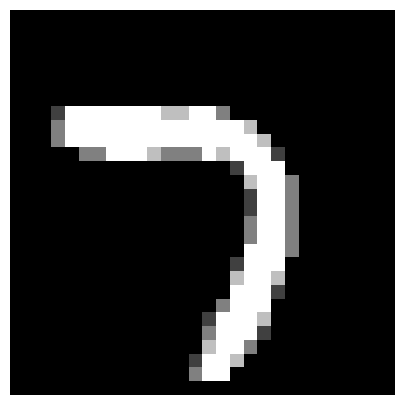

In [20]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [21]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [22]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [23]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cpu


## Compute accuracy 

In [24]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [25]:
def train(model, optimiser, mb_size):
    model = model.to(device=device)
#     for epoch in range(epochs):
    acc = 0.0
    epoch = 0
    while acc < 0.95:
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        epoch += 1
        acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc}')
    

## Modelo usando Sequential

### SGD

In [ ]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 1e-2 #0.378 en 10 epochs
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 0.8593481779098511, accuracy: 0.561767578125
Epoch: 2, costo: 0.515048623085022, accuracy: 0.737548828125
Epoch: 3, costo: 0.33667224645614624, accuracy: 0.921142578125
Epoch: 4, costo: 0.30997470021247864, accuracy: 0.929931640625
Epoch: 5, costo: 0.2121332883834839, accuracy: 0.938720703125
Epoch: 6, costo: 0.2236737608909607, accuracy: 0.920654296875
Epoch: 7, costo: 0.20274005830287933, accuracy: 0.94482421875
Epoch: 8, costo: 0.1482938677072525, accuracy: 0.94970703125
Epoch: 9, costo: 0.2273528277873993, accuracy: 0.9443359375
Epoch: 10, costo: 0.1539945751428604, accuracy: 0.959228515625


### SGD con Momentum

In [28]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 1.9876772165298462, accuracy: 0.69189453125
Epoch: 2, costo: 1.1761800050735474, accuracy: 0.779052734375
Epoch: 3, costo: 0.6348362565040588, accuracy: 0.844970703125
Epoch: 4, costo: 0.48725610971450806, accuracy: 0.882568359375
Epoch: 5, costo: 0.37995514273643494, accuracy: 0.889892578125
Epoch: 6, costo: 0.41155457496643066, accuracy: 0.905517578125
Epoch: 7, costo: 0.36711010336875916, accuracy: 0.910400390625
Epoch: 8, costo: 0.2971840798854828, accuracy: 0.92236328125
Epoch: 9, costo: 0.3063877820968628, accuracy: 0.91845703125
Epoch: 10, costo: 0.3614717423915863, accuracy: 0.92529296875
Epoch: 11, costo: 0.2863810360431671, accuracy: 0.923828125
Epoch: 12, costo: 0.3210009038448334, accuracy: 0.92822265625
Epoch: 13, costo: 0.23954622447490692, accuracy: 0.92578125
Epoch: 14, costo: 0.23363235592842102, accuracy: 0.927001953125
Epoch: 15, costo: 0.2899390459060669, accuracy: 0.9287109375
Epoch: 16, costo: 0.22845616936683655, accuracy: 0.92822265625
Epoch: 17

### RMSProp

In [30]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.RMSprop(model1.parameters(), lr=lr, alpha=0.9)

train(model1, optimiser, mb_size)

Epoch: 1, costo: 1.4771571159362793, accuracy: 0.779296875
Epoch: 2, costo: 0.3331829309463501, accuracy: 0.8984375
Epoch: 3, costo: 0.5055141448974609, accuracy: 0.860595703125
Epoch: 4, costo: 0.2558721899986267, accuracy: 0.852294921875
Epoch: 5, costo: 0.17696291208267212, accuracy: 0.94091796875
Epoch: 6, costo: 0.8774449229240417, accuracy: 0.875244140625
Epoch: 7, costo: 0.23443414270877838, accuracy: 0.88916015625
Epoch: 8, costo: 0.1944485902786255, accuracy: 0.91650390625
Epoch: 9, costo: 3.680096387863159, accuracy: 0.681640625
Epoch: 10, costo: 0.09391411393880844, accuracy: 0.960693359375


### Adam

In [31]:
hidden1 = 1000 
hidden = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

train(model1, optimiser, mb_size)

Epoch: 1, costo: 0.6854056715965271, accuracy: 0.80810546875
Epoch: 2, costo: 0.28847238421440125, accuracy: 0.9306640625
Epoch: 3, costo: 0.17391979694366455, accuracy: 0.9404296875
Epoch: 4, costo: 0.11596562713384628, accuracy: 0.954345703125
